In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# !pip install -U git+https://github.com/qubvel/efficientnet

In [3]:
__file__ = 'EfficientNet-B5-9.7.1-01'
__version__ = 'v11'
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
fold = 3

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time
import efficientnet.keras as efn 

Using TensorFlow backend.


In [5]:
path_data = '../garbage_classify/train_data_v2/'
batch_size = 32
img_size = 456
img_width = img_size
img_height = img_size
random_seed = 201908

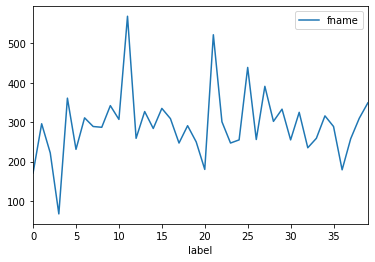

In [6]:
labels_train = pd.read_csv(f'../tmp/labels_train_{__version__}_fold{fold}.csv')
labels_valid = pd.read_csv(f'../tmp/labels_valid_{__version__}_fold{fold}.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [7]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

({0: 1.7187134502923977,
  1: 0.9929054054054054,
  2: 1.3238738738738738,
  3: 4.386567164179104,
  4: 0.8141274238227146,
  5: 1.2722943722943723,
  6: 0.945016077170418,
  7: 1.016955017301038,
  8: 1.0240418118466899,
  9: 0.8593567251461989,
  10: 0.957328990228013,
  11: 0.5165202108963093,
  12: 1.1347490347490348,
  13: 0.8987767584097859,
  14: 1.0348591549295774,
  15: 0.8773134328358209,
  16: 0.9511326860841424,
  17: 1.1898785425101215,
  18: 1.0099656357388316,
  19: 1.1756,
  20: 1.6327777777777779,
  21: 0.5630268199233717,
  22: 0.9764119601328903,
  23: 1.1898785425101215,
  24: 1.1525490196078432,
  25: 0.6694760820045558,
  26: 1.148046875,
  27: 0.7516624040920716,
  28: 0.9731788079470198,
  29: 0.8825825825825826,
  30: 1.1525490196078432,
  31: 0.9043076923076923,
  32: 1.2506382978723405,
  33: 1.1347490347490348,
  34: 0.9300632911392405,
  35: 1.016955017301038,
  36: 1.6418994413407821,
  37: 1.1391472868217054,
  38: 0.9480645161290323,
  39: 0.842120343839

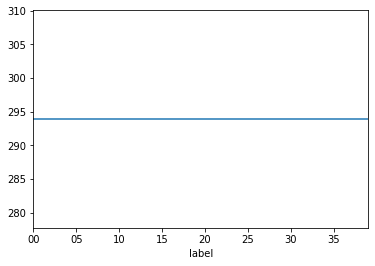

In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(labels_train.label), labels_train.label)
d_class_weights = dict(enumerate(class_weights))
d_class_weights,(labels_train.groupby(by='label').count()['fname'] * class_weights).plot()

In [9]:
ig = ImageDataGenerator(preprocessing_function=efn.preprocess_input,
                        horizontal_flip=True,
                        vertical_flip=True)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(labels_train, path_data, **params_g)
valid_g = ig.flow_from_dataframe(labels_valid[:-(labels_valid.shape[0] % batch_size)], path_data, shuffle=False, **params_g)

Found 11756 validated image filenames belonging to 40 classes.
Found 2912 validated image filenames belonging to 40 classes.


In [10]:
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3),pooling='avg')
for layer in base_model.layers[:-285]:
    layer.trainable=False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
x = base_model.output

x = Dense(128)(x)
x = BatchNormalization()(x)
x=Dropout(0.5)(x)

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}
predictions = Dense(n_classess, activation='softmax',kernel_initializer=DENSE_KERNEL_INITIALIZER)(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [13]:
from keras.utils import multi_gpu_model

model = multi_gpu_model(model,gpus=2)

In [12]:
with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [14]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc',verbose=1)

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=1e-5,verbose=1)

csv_logger = CSVLogger(f'../tmp/training_{__file__}.log',append=True)

In [15]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    class_weight=d_class_weights,
    callbacks=[ckpt, estop,reduce_lr,csv_logger],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
367/367 [==============================] - 412s 1s/step - loss: 1.8847 - acc: 0.5107 - val_loss: 0.6786 - val_acc: 0.8359

Epoch 00001: val_acc improved from -inf to 0.83585, saving model to ../tmp/ckpt-EfficientNet-B5-9.7.1-01-Epoch_001-acc_0.51073-val_acc_0.83585.h5
Epoch 2/100
367/367 [==============================] - 354s 964ms/step - loss: 0.7927 - acc: 0.7832 - val_loss: 0.4320 - val_acc: 0.8939

Epoch 00002: val_acc improved from 0.83585 to 0.89389, saving model to ../tmp/ckpt-EfficientNet-B5-9.7.1-01-Epoch_002-acc_0.78369-val_acc_0.89389.h5
Epoch 3/100
367/367 [==============================] - 354s 966ms/step - loss: 0.5692 - acc: 0.8422 - val_loss: 0.3509 - val_acc: 0.9114

Epoch 00003: val_acc improved from 0.89389 to 0.91140, saving model to ../tmp/ckpt-EfficientNet-B5-9.7.1-01-Epoch_003-acc_0.84255-val_acc_0.91140.h5
Epoch 4/100
367/367 [==============================] - 358s 976ms/step - loss: 0.4423 - acc: 0.88


Epoch 00033: val_acc did not improve from 0.94677
Epoch 34/100
367/367 [==============================] - 352s 960ms/step - loss: 0.0290 - acc: 0.9940 - val_loss: 0.2037 - val_acc: 0.9457

Epoch 00034: val_acc did not improve from 0.94677
Epoch 35/100
367/367 [==============================] - 354s 965ms/step - loss: 0.0268 - acc: 0.9940 - val_loss: 0.1976 - val_acc: 0.9451

Epoch 00035: val_acc did not improve from 0.94677
Epoch 36/100
367/367 [==============================] - 356s 970ms/step - loss: 0.0278 - acc: 0.9937 - val_loss: 0.1921 - val_acc: 0.9499

Epoch 00036: val_acc improved from 0.94677 to 0.94986, saving model to ../tmp/ckpt-EfficientNet-B5-9.7.1-01-Epoch_036-acc_0.99386-val_acc_0.94986.h5
Epoch 37/100
367/367 [==============================] - 349s 951ms/step - loss: 0.0240 - acc: 0.9956 - val_loss: 0.1994 - val_acc: 0.9457

Epoch 00037: val_acc did not improve from 0.94986
Epoch 38/100
367/367 [==============================] - 348s 947ms/step - loss: 0.0312 - acc: 

KeyboardInterrupt: 

In [ ]:
!ls